In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import os

> A type of image-based sequence recognition problem is an optical character recognition problem. And, for a sequence recognition problem, recurrent neural networks (RNN) are best suited, whereas convolution neural networks (CNN) are best suited for an image-based problem (CNN). To deal with OCR issues, we need to combine both of these CNN and RNN.

**We can break the implementation of CRNN network into following steps:**

1. Import Data

2. Data Preprocessing

3. Model Building

4. Defining Loss Function

5. Training Model

6. Decoding Outputs from Prediction

# Import Libraries

In [2]:
%pip install keras
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences


from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Intialize the variable

In [4]:
images = []
labels = []

RECORDS_COUNT = 25000

In [5]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

# Import Data

1. **Personlized Data**

In [8]:
engl=pd.read_csv(r'D:\HTRPipeline-master\Training\Img\english.csv')
engl.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


2. **IAM Dataset**

In [9]:

with open(r"D:\HTRPipeline-master\IAM\IAM\words.txt") as f:
    contents = f.readlines()[18:22539]

lines = [line.strip() for line in contents] 
lines[-1]

'b06-110-07-03 ok 173 987 2031 8 6 . .'

# Data-Preprocessing

**1. Image Pre-processing**

In [10]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

**2. Label-Encoding**

In [11]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


# Personalized Data

In [12]:
for i in range(len(engl)):
 
        splits_id=engl["image"][i].split('/')
        filepath = '../input/english-handwritten-characters-dataset/{}/{}'.format(splits_id[0], 
                                                  splits_id[1])
       
        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # process label
        try:
            word=engl['label'][i]
            label = encode_to_labels(word)
        except:
            continue
        
        if i % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
        if i >= RECORDS_COUNT:
            break

# IAM-Dataset

In [13]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = 'D:/HTRPipeline-master/IAM/words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
      
        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [14]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [15]:
train_labels[3101] 

[70, 67, 56, 65, 55, 60, 65, 58]


> pad each output label to maximum text length

In [16]:
train_padded_label[3101]

array([70, 67, 56, 65, 55, 60, 65, 58, 78, 78, 78, 78, 78, 78, 78, 78, 78])

In [17]:
train_padded_label.shape, valid_padded_label.shape

((18074, 17), (2007, 17))

In [18]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

# Model Building

**Model Description**
1. Input shape for our architecture having an input image of height 32 and width 128.
2. Here we used seven convolution layers of which 6 are having kernel size (3,3) and the last one is of size (2.2). And the number of filters is increased from 64 to 512 layer by layer.
3. Two max-pooling layers are added with size (2,2) and then two max-pooling layers of size (2,1) are added to extract features with a larger width to predict long texts.
4. Also, we used batch normalization layers after fifth and sixth convolution layers which accelerates the training process.
5. Then we used a lambda function to squeeze the output from conv layer and make it compatible with LSTM layer.
6. Then used two Bidirectional LSTM layers each of which has 128 units. This RNN layer gives the output of size (batch_size, 31, 79). Where 79 is the total number of output classes including blank character.

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [20]:
def Model1():
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32,128,1))

    # convolution layer with kernel size (3,3)
    conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
    # poolig layer with kernel size (2,2)
    pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

    conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

    conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

    conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
    # poolig layer with kernel size (2,1)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
    blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

    outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

    # model to be used at test time
    act_model = Model(inputs, outputs)
    
    return act_model,outputs,inputs
    


In [21]:
act_model,outputs,inputs=Model1()

In [22]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [23]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

# Training Model

In [24]:
batch_size = 32
epochs = 5
e = str(epochs)
optimizer_name = 'sgd'

In [25]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]


In [26]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,   
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/5
  3/565 [..............................] - ETA: 17:00 - loss: 61.2375 - accuracy: 0.0000e+00 

KeyboardInterrupt: 

In [29]:
#model.save(filepath='./model3.h5', overwrite=False, include_optimizer=True)

# Performance check

For computing the performance, I will be using the **Jaro-Winkler** algorithm to detect similarity between the captured text and the actual text.

In [30]:

filepath='D:/HTRPipeline-master/Training/sgdo-25000r-3e-18074t-2007v.hdf5'
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)



63/63 [==============================] - 35s 509ms/step


In [31]:
%pip install python-Levenshtein
import Levenshtein as lv

total_jaro = 0

# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
  
print('jaro :', total_jaro/len(out))


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


jaro : 0.8401346208645661


1/1 [==============================] - 0s 97ms/step
original_text =   that
predicted text = thaot

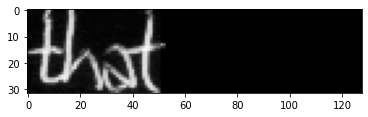



original_text =   want
predicted text = wit

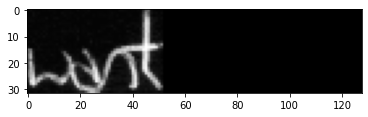



original_text =   in
predicted text = in

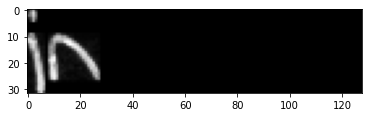



original_text =   ,
predicted text = ,

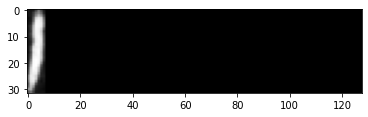



original_text =   .
predicted text = .

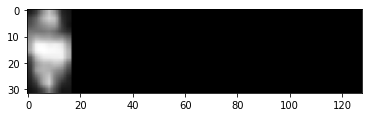

In [32]:
# predict outputs on validation images
i=2000
j=2005
prediction = act_model.predict(valid_images[i:j])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for _, x in enumerate(out):
    
    print("original_text =  ", valid_original_text[i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(valid_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    i+=1
    print('\n')

# Visualization of Loss and Acurracy

In [33]:
#plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [34]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)


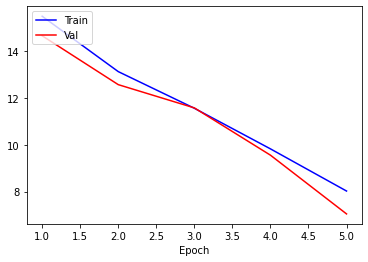

In [35]:
plotgraph(epochs, loss, val_loss)

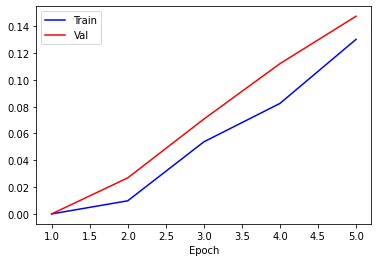

In [36]:
plotgraph(epochs, acc, val_acc)

In [37]:
# get best model index
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [38]:
print(best_loss)
print(best_acc)
print(best_val_acc)

8.022083282470703
0.13024233281612396
0.14748381078243256
